In [1]:
%pip install altair pandas plotly pygal cairosvg ruamel.yaml PrefixedUnit networkx

ERROR: Could not find a version that satisfies the requirement PrefixedUnit (from versions: none)
ERROR: No matching distribution found for PrefixedUnit
Note: you may need to restart the kernel to use updated packages.


In [2]:
"""
    METRICS names come from PAPI
"""
import pandas as pd
import altair as alt
import numpy as np
import plotly.express as px

data = pd.read_csv('ecprof_papi_crayhopt.csv');
data_source2 = pd.read_csv('ecprof_papi_cray.csv');


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 30)


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics

font = {'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

class ComplexRadar():
    def _invert(self, x, limits):
        return limits[1] - (x - limits[0])

    def _scale_data(self, data, ranges):
        """scales data[1:] to ranges[0],
        inverts if the scale is reversed"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        if x1 > x2:
            d = self._invert(d, (x1, x2))
            x1, x2 = x2, x1
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            if y1 > y2:
                d = self._invert(d, (y1, y2))
                y1, y2 = y2, y1
            sdata.append((d-y1) / (y2-y1) 
                         * (x2 - x1) + x1)
        return sdata
    def create_ranges(self, data=None):
        if data is not None:
            return [(data[x].min() - (data[x].max() - data[x].min()) / 5, data[x].max() + (data[x].max() - data[x].min()) / 5) for x in self.labels] 
        # we need to change this formula here somehow
        x = [(self.data[x].min() - (self.data[x].max() - self.data[x].min()) / 5, self.data[x].max() + (self.data[x].max() - self.data[x].min()) / 5) for x in self.labels] 
        return x
        
    def __init__(self, fig, labels, data, functions_to_plot,
                 n_ordinate_levels=6):
        # calculate the ranges and the labels
        self.functions_to_plot = functions_to_plot
        
        self.labels = labels
        self.data = data[0]
        try:
            self.data_second = data[1]
            self.ranges = self.create_ranges(pd.concat([data[0], data[1]]))
        except:
            self.ranges = self.create_ranges()
        
        ranges = self.ranges
        
        angles = np.arange(0, 360, 360./len(labels))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(labels))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=labels, fontweight='bold', fontsize=15)
        axes[0].tick_params(pad=40)
        
        
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
            
        for i, ax in enumerate(axes):
            grid = np.linspace(*self.ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if self.ranges[i][0] > self.ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ax = axes[0]

    def _plot(self, data, label, line='-'):
        sdata = self._scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], line, label=label)

    def plot(self):
        lines = []
        for label in self.functions_to_plot:
            vars_plt = self.data.loc[self.data['Function'] == label][self.labels].values.tolist()[0]
            self._plot(vars_plt, label)
            lines.append(vars_plt)
        try:
            for label in self.functions_to_plot:
                vars_plt = self.data_second.loc[self.data_second['Function'] == label][self.labels].values.tolist()[0]
                self._plot(vars_plt, label, '--')
                lines.append(vars_plt)
        except:
            print('Simple data')
        self.ax.legend(bbox_to_anchor=(1.3, 1))
        return self.ax
    def fill(self, data, *args, **kw):
        sdata = self._scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)



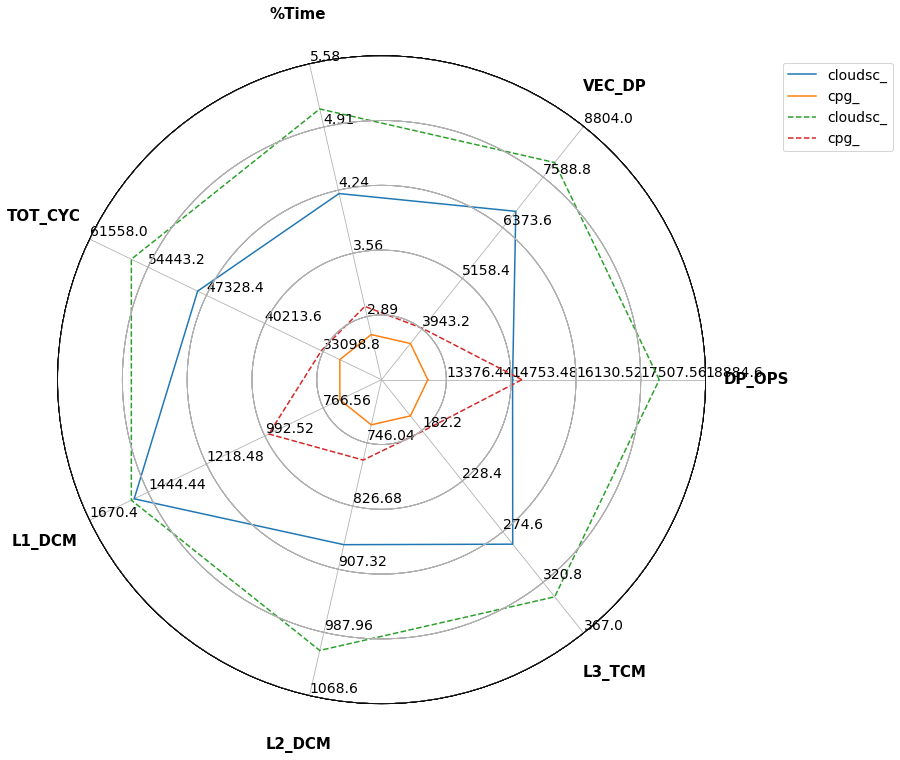

In [46]:
data.head()
functions_to_plot = ['cloudsc_', 'cpg_']
data2 = data.loc[data['Function'].isin(functions_to_plot)]
data_source2_2 = data_source2.loc[data_source2['Function'].isin(functions_to_plot)]

labels = ['DP_OPS', 'VEC_DP', '%Time', 'TOT_CYC', 'L1_DCM', 'L2_DCM', 'L3_TCM']
    
fig1 = plt.figure(figsize=(10, 10));
radar = ComplexRadar(fig1, labels, [data_source2_2, data2], functions_to_plot);
radar.plot().figure.savefig('fig.png');



In [54]:
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px

functions_to_plot = ['cloudsc_', 'cpg_', '__read_nocancel']

df = pd.read_csv("ecprof_papi_crayhopt.csv")
import json
import pprint
import pandas as pd

parsed_dict = dict()
pp = pprint.PrettyPrinter(indent=3)

with open("callgraph.json") as f:
    for i in data.keys():
        for j in data[i]:
            name = j
            if j not in parsed_dict:
                parsed_dict[name] = {}
                # name scope and file
            if name == i:
                parsed_dict[name]['parent'] = None
            else:
                parsed_dict[name]['parent'] = i


df_parents = pd.DataFrame.from_dict(parsed_dict).transpose()
df = df.loc[df["Function"].isin(functions_to_plot)]
df_parents = df_parents.loc[df_parents.index.isin(functions_to_plot) & df_parents.parent.isin(functions_to_plot)]
df = df.set_index('Function').join(df_parents).fillna('').reset_index()

primary_feature = 'WallTime'
features = ['Function',"WallTime", 'parent']

df = df[features]
df = df.to_dict()
df_new = {}
for i in df.keys():
    if i == "Function":
        df_new['function_name'] = list(df[i].values())
    elif i == "WallTime":
        df_new['value'] = list(df[i].values())
    else:
        df_new['parent'] = list(df[i].values())
fig =px.sunburst(
    df_new,
    names='function_name',
    parents='parent',
    values='value',
)

fig.update_layout(width=600,
    height=600,uniformtext=dict(minsize=3, mode='show'))
fig.show()


In [19]:
# Export the drawn figures to html objects that are going to be used in the React app
import plotly
plotly.io.orca.config.executable = '/usr/local/bin/orca'


In [7]:

data = pd.read_csv("example_omp18_papi.csv")
data1 = pd.read_csv("example_omp1_papi.csv")
data = data[['Function', '#Hits']].head(20)
display(data)
fig = px.pie(data, values='#Hits', names='Function', title='Number of cache Hits')
fig.show()


,Function,#Hits
0,save_fluxes,118
1,solver_mcica_lw,112
2,rrtm_taumol3,107
3,solver_homogeneous_sw,78
4,rrtm_kgb7,56
5,solver_homogeneous_lw,52
6,fast_expm_exchange_2,41
7,rrtm_taumol5,28
8,get_real_matrix_indexed,28
9,calc_ice_optics_fu_lw,27


In [ ]:


# hard to do the ifs performance
# it does not play well with comercial available
# also it is hard to understand the data from DrHook
# we need compositions


# talk about the 3 usecases
# talk about the phisycs one
# click on the metrics

###########################
###                     ###
###        DEMO         ###
###                     ###
###########################

# first simple select
# second one is mergeing the performance in multiple compiler caracts in the same
# third one is comparing multiple subrutines in a single spiderweb
# so getting 2 selectors 


# select the labels as well in another selector
# and the way the labels are working are the other way aroung this meaning that 
# leaf: [all of the parents]
# the structure is like this : leaf: call stack


#####################
#   roots selector  #
#####################

######################
#   depth selector   #
######################


# check the OMP-PHYSICS

# CLOUD_SC

# then get a new spider web on
# do then the copy paste and the spider web intertwine
# change the colors in the spiderweb
# compare the way that
# one idea is to compare 2 functions


# the second one is going to be comparing 2 compilers

# the end prototype agile configurable
# the performance analytics be easyer
# better at the job

In [73]:
# graph plots
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import json
import pprint
import pandas as pd
import networkx as nx
import random
from collections import defaultdict

parsed_dict = defaultdict(dict)
nodes = set()
edges = []
pos = None
dim = 2
seed = None
depth = 1

old = 'MASTER' 
labels = []

with open("callgraph.json") as f:
    data = json.load(f)
    for i in data.keys():
        for j in data[i]:
            if old != None:
                parsed_dict[old]['parent'] = j
                parsed_dict[old]['depth'] = len(data[i]) - 1
                parsed_dict[old]['finalParent'] = data[i][-1]
            old = j
        labels.append(data[i][-1])
        parsed_dict[data[i][-1]]['parent'] = 'MASTER'
        parsed_dict[data[i][-1]]['depth'] = 0
        parsed_dict[old]['finalParent'] = data[i][-1]
        
        
        # The last is the top level
        # so it has no parent
        # but also it is a label
        old =  'MASTER' 

parsed_dict = dict(parsed_dict)

In [74]:
# START get depth of the data
depth = 4
data = list(filter(lambda x: parsed_dict[x]['finalParent'] == 'MASTER' and
                   parsed_dict[x]['depth'] < 4,
                     parsed_dict.keys()))
print(data)
newData = set(data)
# for i in data:
#     newData.add(parsed_dict[i]['parent'])
for i in newData:
    local_depth = depth
    parent = parsed_dict[i]['parent']
    local = i
    if parent == None or i == None:
        continue

    while local_depth >= 0:
        edges.append((local, parent))
        if i in newData or parent in newData:
            nodes.add(i)
            nodes.add(parent)
        if i:
            parent = parsed_dict[i]['parent']
        else:
            edges.append((local, ''))
            nodes.add(i)
            nodes.add(parent)
            nodes.add('SourceOfGraph')
            break
        local_depth -= 1
            
# END get depth of the data
            
G = nx.Graph()
G.add_nodes_from(list(nodes))
pos = {v: [random.randint(0, len(edges)) for i in range(dim)] for v in nodes} # TODO this is not good in here 
nx.set_node_attributes(G, pos, "pos")

G.add_edges_from(edges)

edge_x = []
edge_y = []
for edge in G.edges():
    print(G.nodes)
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    mode='lines')
node_x = []
node_y = []
for node in nodes:
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)


node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(line_width=2))

node_adjacencies = []
node_text = []
for node in G.nodes():
    node_text.append(node)

node_trace.text = node_text

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                titlefont_size=16))
fig.show()

['MASTER', 'CNT0', 'SU0YOMA', 'IFS_INIT', 'GRIB_HANDLES_MOD', 'OPDIS', 'FINAL_STATS', 'SUGRIB', 'SUTRANS0', 'DEALXMO', 'FIELDS_MOD:FIELDS_DELETE', 'GSTATS_OUTPUT_IFS', 'IFLUSHFDBSUBS', 'IOSTREAM_MIX:CLOSE_IOSTREAM', 'SULUN', '>MPL-GATHER', 'IOSTREAM_MIX:IOSTREAM_STATS', 'SU_SURF_FLDS', 'FIELD_CONTAINER_GP_MOD', 'SUMP0', 'ALLOCATE_EMPTY_TRAJECTORY', 'SUALTDH', 'SUVAREPS', 'SUALGCO', 'SUCT0', 'FALSIFY_SURF_FLDS', 'SUMDDH', 'SUNUD', 'SUIAU', 'SURES', 'SUPP', 'SU_GRIB_API', 'YOMGSGEOM', 'SUALDYN_DDH', 'FIELDS_MOD', 'SUSC2C', 'SUMPINI_PRT', 'SUALLO', 'SUFP_CTL', 'SUDIMO', 'SURIP0', 'SUTIM', 'SURINC', 'SURLX', 'SULSFORC', 'SUMCUF', 'SUCHET', 'SUMCC', 'GEOMETRY_MOD', 'SUDIMF1', 'SUSAVTEND', 'TESTVAR_MIX', 'SUDIM_TRAJ', 'SPNG_MOD', 'YOMCSGEOM', 'SUPPVI', 'YOMCST', 'GET_SPP_CONF', 'SUETLDIAG', 'SURAND1', 'SUALSPA', 'SUDIMF2', 'supergom_destroy', 'SUCT1', 'SUMSC', 'SUINTFLEX', 'SUECHK', 'SUVWRK', 'supergom_final', 'SUALMDH', 'SUINI', 'YEMLBC_INIT', 'YOE_CUCONVCA', 'YOMGWDIAG', 'SUIOSTREAM', 'MOD